In [3]:
ejecutadoPor = 'Eddie'

##### Por hacer:

1.- Encontrar mejor combinación

2.- Encontrar número máximo de generaciones

-Utilidad por cerrar ciclos tiene muy poco peso en los últimos semestres

##### Notas

Se debería añadir utilidad al llevar materias básicas sobre las de elección libre?

-Al darle un peso mayor a la utilidad de cerrar ciclos, ¿mejorarán los resultados?

-¿Por qué el mejor resultado teórico es mejor que el resultado práctico a pesar de tener mejor desempeno?

El desempeño de la poblacion siempre se estanca porque terminan habiendo muchas cargas inválidas

La utilidad de cerrar ciclos no tiene suficiente relevancia sobre las otras funciones debido a la naturaleza de su cálculo.

##### Cambios:

-Se modificó "obtenerOfertaUtil" para excluir materias de elección libre ya aprobadas de primeros 4 semestres.

-Se cambio función de utilidad disponibilidad de horario

-Error en "RespetaSeriacion", si la materia necesaria ya había sido aprobada retornaba false

In [4]:
import pandas as pd
import numpy as np
import pygad as pg
import time
import requests

# Limpieza y preparación de los datos

## Lectura de datos

In [5]:
d16 = pd.read_csv('./datos/datos_2016.csv')
d17 = pd.read_csv('./datos/datos_2017.csv')
d18 = pd.read_csv('./datos/datos_2018.csv')
d19 = pd.read_csv('./datos/datos_2019.csv')
d2021 = pd.read_csv('./datos/2020_2021.csv')

In [6]:
asignaturas = pd.read_csv('asignaturas2.csv',encoding = 'ISO-8859-1')

In [7]:
plan_2016 = asignaturas.query('plan == "IDP2016"')

In [8]:
oferta = pd.read_csv('oferta_ideio.csv',encoding = 'ISO-8859-1')

In [9]:
seriaciones = pd.read_csv('seriacion.csv')

## Visualización de datos

In [10]:
d16.head()

,Unnamed: 0,carrera,periodo,clave,asignatura,promediofinal,docente,ceveval_global,ceneval_analitico,ceneval_matematico,...,r_modulo8,modulo9,r_modulo9,modulo10,r_modulo10,modulo11,r_modulo11,modulo12,r_modulo12,n_matricula
0,0,Negocios Internacionales,201601,DP0295,Taller de formación en responsabilidad social ...,10.0,Maldonado Saldaña / Gisela,1150.0,1108.0,1228.0,...,-,Cálculo,-,Inglés,-,Administración,-,Informática y Computación,-,140311285
1,1,Negocios Internacionales,201601,NI0215,Taller de software para negocios internacionales,9.0,Villeda Cuellar / Víctor Hugo,1150.0,1108.0,1228.0,...,-,Cálculo,-,Inglés,-,Administración,-,Informática y Computación,-,140311285
2,2,Negocios Internacionales,201601,LI1104,Nivel 4 Inglés,10.0,Ross / Andrew Patrick Simon,1150.0,1108.0,1228.0,...,-,Cálculo,-,Inglés,-,Administración,-,Informática y Computación,-,140311285
3,3,Negocios Internacionales,201601,NI0209,Administración financiera,6.0,Vallejo Filoteo / Jorge,1150.0,1108.0,1228.0,...,-,Cálculo,-,Inglés,-,Administración,-,Informática y Computación,-,140311285
4,4,Negocios Internacionales,201601,NI0213,Transporte y logística en comercio exterior,9.0,Cañedo Magaña / Magdalena del Carmen,1150.0,1108.0,1228.0,...,-,Cálculo,-,Inglés,-,Administración,-,Informática y Computación,-,140311285


In [11]:
d2021.head()

,Unnamed: 0,Column1,programa,periodo,clave,asignatura,docente,promediofinal,ceveval_global,hrs_trabaja,n_matricula
0,0,1,Ingeniería en Datos e Inteligencia Organizacional,202001,IL0414,Taller de argumentación y técnicas de negociación,Torres Pérez / Rubén Juan,7.0,952.0,De 5 a 10 horas,170311163
1,1,2,Ingeniería en Datos e Inteligencia Organizacional,202001,II0422,Taller de emprendedores,Zapata Solís / Zuemy De Lourdes,8.0,1048.0,No trabajaba,180311454
2,2,3,Ingeniería en Datos e Inteligencia Organizacional,202001,DP0498,Problemas de México,Díaz Molina / Libertad Fidelina,9.0,1144.0,De 5 a 10 horas,170311232
3,3,4,Ingeniería en Datos e Inteligencia Organizacional,202001,IT0264,Introducción a los sistemas de información,Olivares González / Oscar,10.0,1072.0,De 11 a 15 horas,190311813
4,4,5,Ingeniería en Datos e Inteligencia Organizacional,202001,II0215,Electricidad y magnetismo,Ramírez Carmona / Leslye Johanna,7.0,1018.0,Más de 20 horas,180311416


In [12]:
asignaturas.head()

,ciclos,clave,nombre,creditos,tipo,plan,preespecialidad
0,1,II0106,Cálculo diferencial,8,Basica,IAP2019,NaN
1,1,II0209,Cálculo integral,6,Basica,IAP2019,NaN
2,1,DP0194,Desarrollo de habilidades del pensamiento,6,Basica,IAP2019,NaN
3,1,IA0106,Ecología,6,Basica,IAP2019,NaN
4,1,II0102,Física experimental,8,Basica,IAP2019,NaN


In [13]:
plan_2016.head()

,ciclos,clave,nombre,creditos,tipo,plan,preespecialidad
603,1,IT0101,Algoritmos y estructura de datos,6,Basica,IDP2016,NaN
604,1,II0106,Cálculo diferencial,8,Basica,IDP2016,NaN
605,1,II0209,Cálculo integral,6,Basica,IDP2016,NaN
606,1,DP0194,Desarrollo de habilidades del pensamiento,6,Basica,IDP2016,NaN
607,1,ID0101,Diseño de patrones para datos estructurados,6,Basica,IDP2016,NaN


In [14]:
oferta.head()

,Ciclo,Trayectoria,Tipo,Clave,Nombre,Maestro,Lunes,Martes,Miercoles,Jueves,Viernes,Sabado
0,1,0,BAS,DP0193,Taller de redacción profesional,Alvarado Martínez / María Del Carmen,-,-,17:00-18:00,-,16:00-18:00,-
1,1,0,BAS,DP0191,Taller de interacción grupal y competencias co...,Diaz Barriga Cuevas / Claudia,-,-,-,15:00-17:00,17:00-18:00,-
2,1,0,BAS,DP0191,Taller de interacción grupal y competencias co...,Diaz Barriga Cuevas / Claudia,18:00-20:00,-,-,17:00-18:00,-,-
3,1,0,BAS,DP0193,Taller de redacción profesional,Parra Dorantes / Roberto,-,-,18:00-20:00,-,17:00-18:00,-
4,1,0,BAS,DP0194,Desarrollo de habilidades del pensamiento,Mendoza Luna / José Arturo,-,-,19:00-20:00,-,20:00-22:00,-


In [15]:
seriaciones.head()

,plan,ser1,ser2
0,IDP2016,II0106,II0209
1,IDP2016,ID0102,II0215
2,IDP2016,II0209,II0320
3,IDP2016,ID0103,IT0263
4,IDP2016,IT0264,ID0204


## Limpieza de datos

In [16]:
cargas16_19 = pd.concat([d16,d17,d18,d19])
cargas20_21 = d2021

In [17]:
cargas16_19 = cargas16_19.query('carrera == "Ingeniería en Datos e Inteligencia Organizacional"')

In [18]:
cargas16_19 = cargas16_19[['Unnamed: 0', 'carrera', 'periodo', 'clave', 'asignatura',
       'promediofinal', 'docente', 'ceveval_global', 'ceneval_analitico',
       'ceneval_matematico', 'ceneval_lengua', 'ceneval_esp',
       'n_matricula']]

In [19]:
matriculas16 = cargas16_19.query('n_matricula > 160000000 and n_matricula < 170000000')['n_matricula'].unique()
matriculas17 = cargas16_19.query('n_matricula > 170000000 and n_matricula < 180000000')['n_matricula'].unique()
matriculas18 = cargas16_19.query('n_matricula > 180000000 and n_matricula < 190000000')['n_matricula'].unique()
matriculas19 = cargas16_19.query('n_matricula > 190000000 and n_matricula < 200000000')['n_matricula'].unique()
matriculas20 = cargas20_21.query('n_matricula > 200000000 and n_matricula < 210000000')['n_matricula'].unique()
matriculas21 = cargas20_21.query('n_matricula > 210000000 and n_matricula < 220000000')['n_matricula'].unique()

In [20]:
matriculas = np.concatenate((matriculas16, matriculas17,matriculas18,matriculas19,matriculas20,matriculas21))

In [21]:
cargas20_21 = cargas20_21.rename(columns={'programa': 'carrera'})

In [22]:
formato_cargas20_21 = cargas20_21[['carrera', 'periodo', 'clave', 'asignatura','docente','n_matricula','promediofinal']]
formato_cargas16_19 = cargas16_19[['carrera', 'periodo', 'clave', 'asignatura','docente','n_matricula','promediofinal']]

formato_cargas = pd.concat([formato_cargas16_19,formato_cargas20_21])

In [23]:
oferta = oferta[['Clave','Nombre', 'Maestro', 'Lunes','Martes', 'Miercoles', 'Jueves', 'Viernes', 'Sabado']]

In [24]:
oferta['Lunes'].unique()

array(['-', '18:00-20:00', '17:00-19:00', '20:00-22:00', '15:00-17:00',
       '9:00-11:00', '19:00-21:00', '19:00-20:00', '7:00-9:00',
       '11:00-13:00', '13:00-14:00', '16:00-18:00', '14:00-16:00',
       '7:00-10:00', '7:00-8:00', '16:00-19:00', '21:00-22:00',
       '16:00-17:00'], dtype=object)

In [25]:
oferta['Martes'].unique()

array(['-', '15:00-17:00', '20:00-21:00', '20:00-22:00', '19:00-20:00',
       '16:00-18:00', '18:00-19:00', '7:00-9:00', '9:00-11:00',
       '18:00-20:00', '14:00-16:00', '13:00-15:00', '8:00-9:00'],
      dtype=object)

In [26]:
oferta['Miercoles'].unique()

array(['17:00-18:00', '-', '18:00-20:00', '19:00-20:00', '16:00-17:00',
       '15:00-17:00', '20:00-21:00', '20:00-22:00', '18:00-19:00',
       '12:00-14:00', '7:00-9:00', '9:00-11:00', '11:00-12:00',
       '11:00-13:00', '\n13:00-15:00', '13:00-15:00', '17:00-19:00',
       '19:00-21:00', '15:00-16:00', '12:00-13:00', '8:00-10:00',
       '7:00-8:00', '10:00-12:00', '16:00-18:00', '14:00-15:00'],
      dtype=object)

In [27]:
oferta['Jueves'].unique()

array(['-', '15:00-17:00', '17:00-18:00', '20:00-21:00', '16:00-17:00',
       '9:00-10:00', '20:00-22:00', '18:00-20:00', '19:00-21:00',
       '7:00-8:00', '13:00-14:00', '8:00-9:00', '9:00-11:00',
       '16:00-18:00', '14:00-15:00', '13:00-15:00', '7:00-9:00',
       '15:00-16:00', '18:00-19:00', '19:00-20:00', '21:00-22:00'],
      dtype=object)

In [28]:
oferta['Viernes'].unique()

array(['16:00-18:00', '17:00-18:00', '-', '20:00-22:00', '15:00-17:00',
       '14:00-15:00', '18:00-20:00', '20:00-21:00', '13:00-14:00',
       '9:00-10:00', '7:00-9:00', '10:00-11:00', '16:00-17:00',
       '14:00-16:00', '18:00-19:00', '8:00-10:00', '19:00-20:00',
       '19:00-21:00'], dtype=object)

In [29]:
oferta.loc[36,'Miercoles'] = '13:00-15:00'

In [30]:
oferta['Miercoles'].unique()

array(['17:00-18:00', '-', '18:00-20:00', '19:00-20:00', '16:00-17:00',
       '15:00-17:00', '20:00-21:00', '20:00-22:00', '18:00-19:00',
       '12:00-14:00', '7:00-9:00', '9:00-11:00', '11:00-12:00',
       '11:00-13:00', '13:00-15:00', '17:00-19:00', '19:00-21:00',
       '15:00-16:00', '12:00-13:00', '8:00-10:00', '7:00-8:00',
       '10:00-12:00', '16:00-18:00', '14:00-15:00'], dtype=object)

In [31]:
def formatoHora(hora):
    if len(hora) == 11:
        return hora
    elif len(hora) == 10:
        return '0' + hora
    elif len(hora) == 9:
        return '0' + hora[0:5] + '0' + hora[5:]
    elif len(hora) == 1:
        return '-'

In [32]:
oferta['Lunes'] = oferta['Lunes'].apply(lambda horas: formatoHora(horas))
oferta['Martes'] = oferta['Martes'].apply(lambda horas: formatoHora(horas))
oferta['Miercoles'] = oferta['Miercoles'].apply(lambda horas: formatoHora(horas))
oferta['Jueves'] = oferta['Jueves'].apply(lambda horas: formatoHora(horas))
oferta['Viernes'] = oferta['Viernes'].apply(lambda horas: formatoHora(horas))

# Definición de funciones útiles

## Función para obtener un Kardex aleatorio

In [33]:
def obtenerKardex(mat = -1):
    if(mat == -1):
        mat = np.random.choice(matriculas)
    return formato_cargas.query('n_matricula == ' + str(mat)).sort_values('periodo')

In [34]:
def obtenerCreditos(kardex):
    claves = kardex.query('promediofinal >= 7')['clave'].unique()
    totalCreditos = 0
    for clave in claves:
        if(clave[0:2] == 'LI' or clave[0:2] == 'TA' or clave[0:2] == 'AD'):
            continue
        totalCreditos += plan_2016.query('clave == "' + clave + '"')['creditos'].values[0]
    return totalCreditos

## Obtención de oferta útil

En este sección se crea la función "obtenerOfertaUtil" la cual filtra la oferta académica para eliminar las materias que no cumplen con la restricción de llevar materias aprobadas y la restricción de llevar materias que no respeten la seriación.

In [35]:
def materiaHaSidoAprobada(kardex,clave):
    if len(kardex.query('clave == "' + clave + '" and promediofinal >= 7')) == 0:
        return False
    else:
        return True

In [36]:
def respetaSeriacion(clave,kardex):
    if len(seriaciones.query('ser2 == "' + clave + '"')) == 0:
        return True
    else:
        #Se guarda en necesarias la lista de asignaturas necesarias para llevar la asignura "clave"
        necesarias = seriaciones.query('ser2 == "' + clave + '"')['ser1'].unique()
        
        #Se recorre la lista para comprobar si el estudiante ya pasó las asignaturas necesarias, en caso de que le falte 
        #al menos una, entonces no se respeta la seriación.
        for necesaria in necesarias:
            if not(materiaHaSidoAprobada(kardex,necesaria)):
                return False
        return True

In [37]:
#Filtra las materias que no cumplen las restricciones 1 y 2

def obtenerOfertaUtil(kardex,oferta):
    #Se eliminan las materias en la oferta que ya han sido aprobadas
    aprobadas = kardex.query('promediofinal >= 7')['clave'].unique()
    for clave in aprobadas:
        oferta = oferta.query('Clave != "' + clave + '"')
        
    #Se eliminan las materias que el alumno no puede llevar por la seriación
    ofertaUtilIndex = set(oferta.index.values)
    for idx in oferta.index:
        if not(respetaSeriacion(oferta.loc[idx]['Clave'],kardex)):
            ofertaUtilIndex.remove(idx)
            
    #Se eliminan prácticas profesionales y proyecto terminal
    for i in range(len(oferta['Clave'].values)):
        clave = oferta['Clave'].values[i]
        if clave[0:3] == 'PID' or clave == 'IT0427':
            try:
                ofertaUtilIndex.remove(oferta.index.values[i])
            except:
                continue
    ofertaUtil = oferta.loc[list(ofertaUtilIndex)]
    
    #Se eliminan materias de elección libre de primer y segundo ciclo
    if(materiaHaSidoAprobada(kardex,'IL0102')):
        ofertaUtil = ofertaUtil.query('Clave != "ID0160"')
    if(materiaHaSidoAprobada(kardex,'ID0160')):
        ofertaUtil = ofertaUtil.query('Clave != "IL0102"')
    
    if(materiaHaSidoAprobada(kardex,'IT0103')):
        ofertaUtil = ofertaUtil.query('Clave != "ID0161"')
    if(materiaHaSidoAprobada(kardex,'ID0161')):
        ofertaUtil = ofertaUtil.query('Clave != "IT0103"')
        
    if(materiaHaSidoAprobada(kardex,'ID0264')):
        ofertaUtil = ofertaUtil.query('Clave != "ID0262"')
    if(materiaHaSidoAprobada(kardex,'ID0262')):
        ofertaUtil = ofertaUtil.query('Clave != "ID0264"')
        
    if(materiaHaSidoAprobada(kardex,'ID0263')):
        ofertaUtil = ofertaUtil.query('Clave != "ID0265"')
    if(materiaHaSidoAprobada(kardex,'ID0265')):
        ofertaUtil = ofertaUtil.query('Clave != "ID0263"')
        
    
    return ofertaUtil

In [38]:
oferta.query('Clave != "ID0161"')

,Clave,Nombre,Maestro,Lunes,Martes,Miercoles,Jueves,Viernes,Sabado
0,DP0193,Taller de redacción profesional,Alvarado Martínez / María Del Carmen,-,-,17:00-18:00,-,16:00-18:00,-
1,DP0191,Taller de interacción grupal y competencias co...,Diaz Barriga Cuevas / Claudia,-,-,-,15:00-17:00,17:00-18:00,-
2,DP0191,Taller de interacción grupal y competencias co...,Diaz Barriga Cuevas / Claudia,18:00-20:00,-,-,17:00-18:00,-,-
3,DP0193,Taller de redacción profesional,Parra Dorantes / Roberto,-,-,18:00-20:00,-,17:00-18:00,-
4,DP0194,Desarrollo de habilidades del pensamiento,Mendoza Luna / José Arturo,-,-,19:00-20:00,-,20:00-22:00,-
...,...,...,...,...,...,...,...,...,...
112,IT0427,Proyecto terminal,Zavala López / Erika Erendira,16:00-19:00,-,-,-,-,-
113,ID3424,Visualización de datos,Mendiola Fuentes / Jessica Carmin,07:00-08:00,-,-,-,07:00-09:00,-
114,DP0498,Problemas de México,Manzo de León / Leonela Paola,18:00-20:00,-,-,-,18:00-19:00,-
115,DP0499,Seminario de investigación,Reyes Miranda / José Felipe,14:00-16:00,-,14:00-15:00,-,-,-


## Generación de carga aleatoria válida

#### NOTA: Tomar en cuenta materias repetidas y por ahora descartar talleres deportivos, artísticos, lengua inglesa y prácticas profesionales

En esta sección creamos las funciones "generarCargaValida" la cual retorna una string de bits representando una carga académica con base a la oferta útil. También se crea la función "obtenerDatosCarga" que nos ayuda a obtener los datos de una carga académica con base a la oferta útil y a una string de bits que denominamos "bits de carga"

In [39]:
def generarSolucionAleatoria(ofertaUtil):
    solucion = [-1] * 9
    for i in range(9):
        gen = np.random.randint(-1,len(ofertaUtil))
        if gen == -1:
            solucion[i] = -1
        else:
            solucion[i] = ofertaUtil.index[gen]
    return solucion

In [40]:
def obtenerDatosCarga(solucion,ofertaUtil):
    solucionU = np.array(solucion)
    solucionU = np.unique(solucionU)
    solucionU = solucionU[solucionU >= 0]
    
    return ofertaUtil.loc[solucionU]

In [41]:
def comprobarTraslapacion(solucion,ofertaUtil):
    datosCarga = obtenerDatosCarga(solucion,ofertaUtil)
    dias = ['Lunes','Martes','Miercoles','Jueves','Viernes','Sabado']
    
    for dia in dias:
        horarioDia = datosCarga.sort_values(dia)[dia].values
        for i in range(len(horarioDia)):
            if horarioDia[i] == '-':
                continue
            horaInicioI = int(horarioDia[i][0:2])
            horaFinI = int(horarioDia[i][6:8])
            
            for j in range(i+1,len(horarioDia)):
                horaInicioJ = int(horarioDia[j][0:2])
                horaFinJ = int(horarioDia[j][6:8])
                
                if not(horaFinJ  <= horaInicioI or horaInicioJ >= horaFinI):
                    return True
    return False

In [42]:
def esValido(solucion,ofertaUtil):
    #Si se repite una materia es inválido
    datosCarga = obtenerDatosCarga(solucion,ofertaUtil)
    if len(datosCarga['Clave'].unique()) < len(datosCarga):
        return False
    #Si se traslapan dos materias es inválido
    if comprobarTraslapacion(solucion,ofertaUtil):
        return False
    return True

In [43]:
def generarSolucionValida(ofertaUtil):
    bitsDeCarga = generarSolucionAleatoria(ofertaUtil)
    
    while not(esValido(bitsDeCarga,ofertaUtil)):
        bitsDeCarga = generarSolucionAleatoria(ofertaUtil)
    
    return bitsDeCarga

In [44]:
def obtenerHorario(carga,ofertaUtil):
    primeraHoraMinima = 24
    ultimaHoraMaxima = 0
    datosCarga = obtenerDatosCarga(carga,ofertaUtil)
    horario = pd.DataFrame({
        'Hora': ['7:00-8:00','8:00-9:00','9:00-10:00','10:00-11:00','11:00-12:00','12:00-13:00','13:00-14:00','14:00-15:00','15:00-16:00','16:00-17:00','17:00-18:00','18:00-19:00','19:00-20:00','20:00-21:00','21:00-22:00'],
        'Lunes': ['-','-','-','-','-','-','-','-','-','-','-','-','-','-','-'],
        'Martes': ['-','-','-','-','-','-','-','-','-','-','-','-','-','-','-'],
        'Miercoles': ['-','-','-','-','-','-','-','-','-','-','-','-','-','-','-'],
        'Jueves': ['-','-','-','-','-','-','-','-','-','-','-','-','-','-','-'],
        'Viernes': ['-','-','-','-','-','-','-','-','-','-','-','-','-','-','-'],
        'Sabado': ['-','-','-','-','-','-','-','-','-','-','-','-','-','-','-'],
    })
    dias = ['Lunes','Martes','Miercoles','Jueves','Viernes','Sabado']
    for dia in dias:
        for i in range(len(datosCarga)):
            if datosCarga[dia].iloc[i] == '-':
                continue

            horaInicio = int(datosCarga.iloc[i][dia][0:2])
            horaFin = int(datosCarga.iloc[i][dia][6:8])
            
            primeraHoraMinima = min(primeraHoraMinima,horaInicio)
            ultimaHoraMaxima = max(ultimaHoraMaxima,horaFin)
            
            nombre = datosCarga.iloc[i]['Nombre']

            for hora in range(horaInicio,horaFin):
                horario.loc[hora-7,dia]=nombre
    return horario[(primeraHoraMinima-7):(ultimaHoraMaxima-6)]

# Definición de funciones de utilidad y de costo

## Utilidad de carga académica con base en las materias reprobadas

In [45]:
def obtenerMateriasReprobadas(kardex):
    materiasReprobadas = kardex.query('promediofinal < 7')['clave'].unique()
    materiasReprobadasFinal = []
    for clave in materiasReprobadas:
        aprobado = len(kardex.query('clave == "' + clave + '" and promediofinal >= 7'))
        if aprobado == 0:
            materiasReprobadasFinal.append(clave)
    return materiasReprobadasFinal

In [46]:
def UpMR(kardex,solucion,ofertaUtil):
    materiasReprobadas = obtenerMateriasReprobadas(kardex)
    if len(materiasReprobadas) == 0:
        return 0
    datosCarga = obtenerDatosCarga(solucion,ofertaUtil)
    utilidadTotal = 0
    
    for clave in materiasReprobadas:
        cargado = len(datosCarga.query('Clave == "' + clave + '"'))
        if cargado == 1:
            utilidadTotal += 1
            
    
    #Normalización
    utilidad = (utilidadTotal)/(len(materiasReprobadas))
    return utilidad

## Utilidad de carga académica con base en el cierre de ciclos

In [47]:
def UpCC(solucion,ofertaUtil):
    alpha = 3
    utilidad = [alpha**3,alpha**2,alpha,1]
    utilidadTotal = 0
    
    datosCarga = obtenerDatosCarga(solucion,ofertaUtil)
    
    claves = datosCarga['Clave'].unique()
    for i in range(len(claves)):
        if claves[i][0:2] == 'AD'or claves[i][0:2] == 'TA' or claves[i][0:2] == 'LI' or claves[i][0:2] == 'PI':
            continue
            
        ciclo = int(plan_2016.query('clave == "' + claves[i] + '"')['ciclos'])
        utilidadTotal += utilidad[ciclo-1]
    
    #Normalización
    utilidadNorm = (utilidadTotal)/(utilidad[0]*9)
    return utilidadNorm

## Costo de carga académica con base en las horas libres

#### NOTA: Tomar en cuenta las horas libres por día

In [48]:
    def CpHL(solucion,ofertaUtil):
        dias = ['Lunes','Martes','Miercoles','Jueves','Viernes','Sabado']
        costoTotal = 0
        hlMax = 0

        datosCarga = obtenerDatosCarga(solucion,ofertaUtil)

        for dia in dias:
            datosCarga = datosCarga.sort_values(dia)
            if datosCarga[dia].iloc[len(datosCarga)-2] == '-':
                continue

            ultimaHoraFin = 0
            for i in range(len(datosCarga)):
                if datosCarga.iloc[i][dia] == '-':
                    continue
                if ultimaHoraFin == 0:
                    ultimaHoraFin = int(datosCarga.iloc[i][dia][6:8])
                    primeraHoraDia = int(datosCarga.iloc[i][dia][0:2])
                    continue
                horaInicio = int(datosCarga.iloc[i][dia][0:2])
                costoTotal += (horaInicio - ultimaHoraFin)
                ultimaHoraFin = int(datosCarga.iloc[i][dia][6:8])
            hlMax += (ultimaHoraFin - primeraHoraDia - 2)

        if hlMax == 0:
            return 0
        #Normalización
        costo = (costoTotal)/(hlMax)
        return costo

## Costo de carga académica con base en la disponibilidad de horario del estudiante

Creamos 4 casos diferentes donde los estudiantes trabajan. Guardamos el horario de ocupación de los estudiantes en un dataframe por cada estudiante.

In [49]:
# El estudiante trabaja por las mañanas tiempo completo
disp_est_1 = pd.DataFrame({
    "hora": [7,8,9,10,11,12,13,14,15,16,17,18,19,20,21],
    "Lunes": [False,False,False,False,False,False,False,False,False,True,True,True,True,True,True],
    "Martes": [False,False,False,False,False,False,False,False,False,True,True,True,True,True,True],
    "Miercoles": [False,False,False,False,False,False,False,False,False,True,True,True,True,True,True],
    "Jueves": [False,False,False,False,False,False,False,False,False,True,True,True,True,True,True],
    "Viernes": [False,False,False,False,False,False,False,False,False,True,True,True,True,True,True],
    "Sabado": [False,False,False,False,False,False,False,False,False,True,True,True,True,True,True]
})


# El estudiante trabaja por las tardes tiempo completo
disp_est_2 = pd.DataFrame({
    "hora": [7,8,9,10,11,12,13,14,15,16,17,18,19,20,21],
    "Lunes": [True,True,True,True,True,True,False,False,False,False,False,False,False,False,False],
    "Martes": [True,True,True,True,True,True,False,False,False,False,False,False,False,False,False],
    "Miercoles": [True,True,True,True,True,True,False,False,False,False,False,False,False,False,False],
    "Jueves": [True,True,True,True,True,True,False,False,False,False,False,False,False,False,False],
    "Viernes": [True,True,True,True,True,True,False,False,False,False,False,False,False,False,False],
    "Sabado": [True,True,True,True,True,True,False,False,False,False,False,False,False,False,False]
})

# El estudiante trabaja por las mañanas medio tiempo
disp_est_3 = pd.DataFrame({
    "hora": [7,8,9,10,11,12,13,14,15,16,17,18,19,20,21],
    "Lunes": [True,False,False,False,False,False,True,True,True,True,True,True,True,False,False],
    "Martes": [True,False,False,False,False,False,True,True,True,True,True,True,True,False,False],
    "Miercoles": [True,False,False,False,False,False,True,True,True,True,True,True,True,False,False],
    "Jueves": [True,False,False,False,False,False,True,True,True,True,True,True,True,False,False],
    "Viernes": [True,False,False,False,False,False,True,True,True,True,True,True,True,False,False],
    "Sabado": [True,False,False,False,False,False,True,True,True,True,True,True,True,False,False]
})
# El estudiante trabaja por las tardes medio tiempo
disp_est_4 = pd.DataFrame({
    "hora": [7,8,9,10,11,12,13,14,15,16,17,18,19,20,21],
    "Lunes": [True,True,True,True,True,False,False,False,False,False,True,True,True,True,True],
    "Martes": [True,True,True,True,True,False,False,False,False,False,True,True,True,True,True],
    "Miercoles": [True,True,True,True,True,False,False,False,False,False,True,True,True,True,True],
    "Jueves": [True,True,True,True,True,False,False,False,False,False,True,True,True,True,True],
    "Viernes": [True,True,True,True,True,False,False,False,False,False,True,True,True,True,True],
    "Sabado": [True,True,True,True,True,False,False,False,False,False,True,True,True,True,True]
})
disp_est_5 = pd.DataFrame({
    "hora": [7,8,9,10,11,12,13,14,15,16,17,18,19,20,21],
    "Lunes": [True,True,True,True,True,True,True,True,True,True,True,True,True,True,True],
    "Martes": [True,True,True,True,True,True,True,True,True,True,True,True,True,True,True],
    "Miercoles": [True,True,True,True,True,True,True,True,True,True,True,True,True,True,True],
    "Jueves": [True,True,True,True,True,True,True,True,True,True,True,True,True,True,True],
    "Viernes": [True,True,True,True,True,True,True,True,True,True,True,True,True,True,True],
    "Sabado": [True,True,True,True,True,True,True,True,True,True,True,True,True,True,True]
})

In [50]:
disponibilidadArr = [disp_est_1,disp_est_2,disp_est_3,disp_est_4,disp_est_5]

In [51]:
def CpDH(solucion,ofertaUtil,disponibilidad):
    disponibilidadTotal = sum(disponibilidad['Lunes']) + sum(disponibilidad['Martes']) + sum(disponibilidad['Miercoles']) + sum(disponibilidad['Jueves']) + sum(disponibilidad['Viernes']) + sum(disponibilidad['Sabado'])
    if disponibilidadTotal == 90:
        return 0
    
    dias = ['Lunes','Martes','Miercoles','Jueves','Viernes','Sabado']
    datosCarga = obtenerDatosCarga(solucion,ofertaUtil)
    costoTotal = 0

    for dia in dias:
        for i in range(len(datosCarga)):
            if datosCarga[dia].iloc[i] == '-':
                continue

            horaInicio = int(datosCarga.iloc[i][dia][0:2])
            horaFin = int(datosCarga.iloc[i][dia][6:8])

            for hora in range(horaInicio,horaFin):
                if not(disponibilidad.query('hora == ' + str(hora))[dia].values[0]):
                    costoTotal += 1
                    
    #Normalización
    costo = (costoTotal)/(90 - disponibilidadTotal)
    return costo

# Definición de la función de desempeño

In [52]:
def obtenerDesempeno(solucion,cromosomaIndice):
    if not(esValido(solucion,ofertaUtil)):
        return 0
    pesos = np.array([1,1,1,1])   
    
    upcc = UpCC(solucion,ofertaUtil)
    upmr = UpMR(kardex,solucion,ofertaUtil)
    cpdh = CpDH(solucion,ofertaUtil,disponibilidad)
    cphl = CpHL(solucion,ofertaUtil)
    
    x = np.array([upcc,upmr,cpdh,cphl])
    x = x*pesos
    
    x[2] =  pesos[2]- x[2]
    x[3] = pesos[3] - x[3]
    
    return sum(x)

In [53]:
def evaluarSolucion(solucion):
    pesos = np.array([1,1,1,1])   
    
    upcc = UpCC(solucion,ofertaUtil)
    upmr = UpMR(kardex,solucion,ofertaUtil)
    cpdh = CpDH(solucion,ofertaUtil,disponibilidad)
    cphl = CpHL(solucion,ofertaUtil)
    
    print("La carga evaluada tiene:")
    print("\t" + str(round(100*upcc,2)) + "% de utilidad por las materias de primeros ciclos llevadas.")
    print("\t" + str(round(100*upmr,2)) + "% del total de las materias reprobadas del estudiante.") 
    print("\t" + str(round(100*cpdh,2)) + "% de costo por sobreposición con las horas donde el estudiante no está disponible.")
    print("\t" + str(round(100*cphl,2)) + "% de costo por el total de horas libres por día.")

### Problemas a solucionar:

-Función de horas libres no toma en cuenta el promedio de horas libres por día (Hacer otra función?)

-¿La función objetivo de regresar un promedio o una suma de las demás funciones?

-Arreglar costo por horas libres, regresa valores negativos

# Algoritmos evolutivos

## Prueba #1

In [54]:
#Matricula Eddie = 190311499

In [55]:
kardex = obtenerKardex(190311499).query('periodo < 202201')
disponibilidad = disponibilidadArr[4] #Disponibilidad completa de horario
ofertaUtil = obtenerOfertaUtil(kardex,oferta)

In [56]:
#Obtener un kardex con al menos la mitad de creditos y al menos 3 materias reprobadas
#kardex = obtenerKardex()
#while obtenerCreditos(kardex) < 200 or len(obtenerMateriasReprobadas(kardex))  <= 2:
#    kardex = obtenerKardex()
#ofertaUtil = obtenerOfertaUtil(kardex,oferta)

In [57]:
obtenerCreditos(kardex)

240

In [58]:
obtenerMateriasReprobadas(kardex)

[]

In [59]:
ofertaUtil

,Clave,Nombre,Maestro,Lunes,Martes,Miercoles,Jueves,Viernes,Sabado
58,IL3422,Liderazgo y equipos de trabajo,García Rivera / Miriam Angelica,-,-,15:00-16:00,-,14:00-16:00,-
61,II0422,Taller de emprendedores,Contreras Macossay / Bani Obed,-,09:00-11:00,11:00-12:00,-,-,-
65,II0422,Taller de emprendedores,Arreola Mejía / Sonia Amalia,-,13:00-15:00,-,13:00-14:00,-,-
66,DP0498,Problemas de México,Cervera León / José Samuel,-,09:00-11:00,-,-,10:00-11:00,-
67,ID0307,Ingeniería de software,Morales Saavedra / Emmanuel,11:00-13:00,-,12:00-13:00,-,-,-
68,ID0310,Minería de datos,Gómez García / Hector Fernando,-,-,08:00-10:00,-,08:00-10:00,-
69,ID3416,Diseño multimedia,Landeros Alvarado / Aurea,-,08:00-09:00,-,09:00-11:00,-,-
70,ID3468,Herramientas para la gestión de grandes volúme...,Mendiola Fuentes / Jessica Carmin,09:00-11:00,-,-,13:00-14:00,-,-
71,II0422,Taller de emprendedores,Treviño Arzápalo / Ángel Alejandro,07:00-09:00,-,07:00-08:00,-,-,-
72,IT0263,Electrónica analógica,Casas De La Cruz / Rosa Guadalupe,13:00-14:00,-,10:00-12:00,-,-,-


In [60]:
fitness_function = obtenerDesempeno

num_generations = 30      #Número de generaciones
num_parents_mating = 2    #Número de padres por hijo

sol_per_pop = 500        #Tamaño de la poblacion
num_genes = 9             #Tamaño del cromosoma

gene_type = int           #Tipo de dato de los genes del cromosoma

parent_selection_type = "tournament"
keep_parents = 1          #Mantener a los padres vivos (La poblacion crece)

crossover_type = "two_points"

mutation_type = "random"
mutation_percent_genes = 15

gene_space = np.append(ofertaUtil.index.values,[-1])     #Valores que pueden tomar los genes

In [61]:
def on_generation(ga_instance):
    if ga_instance.num_generations > 100:
        if ga_instance.generations_completed % (ga_instance.num_generations / 100) == 0:
            print(str(ga_instance.generations_completed / (ga_instance.num_generations / 100)) + "%")
    else:
        print("Generación: " + str(ga_instance.generations_completed))

In [62]:
ga_instance = pg.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                       gene_type=gene_type,
                       gene_space=gene_space,
                       on_generation=on_generation)

In [63]:
start_time = time.time()
ga_instance.run()
print("--- Proceso terminado en: %s segundos---" % (time.time() - start_time))

Generación: 1
Generación: 2
Generación: 3
Generación: 4
Generación: 5
Generación: 6
Generación: 7
Generación: 8
Generación: 9
Generación: 10
Generación: 11
Generación: 12
Generación: 13
Generación: 14
Generación: 15
Generación: 16
Generación: 17
Generación: 18
Generación: 19
Generación: 20
Generación: 21
Generación: 22
Generación: 23
Generación: 24
Generación: 25
Generación: 26
Generación: 27
Generación: 28
Generación: 29
Generación: 30
--- Proceso terminado en: 14.61247968673706 segundos---


In [64]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()

In [65]:
solution_fitness

1.9078822412155745

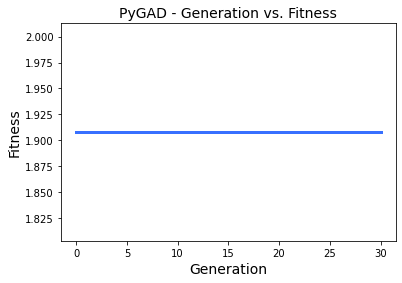

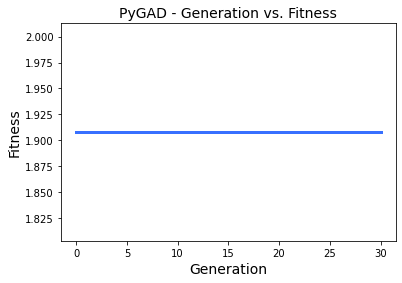

In [66]:
ga_instance.plot_fitness()

**Nota:** Esta carga tiene un mejor resultado práctico que el resultado ideal.

In [67]:
obtenerDatosCarga(solution,ofertaUtil)

,Clave,Nombre,Maestro,Lunes,Martes,Miercoles,Jueves,Viernes,Sabado
67,ID0307,Ingeniería de software,Morales Saavedra / Emmanuel,11:00-13:00,-,12:00-13:00,-,-,-
72,IT0263,Electrónica analógica,Casas De La Cruz / Rosa Guadalupe,13:00-14:00,-,10:00-12:00,-,-,-
76,ID3422,Negocios digitales,Rodríguez Santiago / Juan Manuel,-,18:00-20:00,-,18:00-19:00,-,-
77,ID3468,Herramientas para la gestión de grandes volúme...,Mendiola Fuentes / Jessica Carmin,18:00-20:00,-,-,19:00-20:00,-,-
108,IT0317,Diseño de interfaces humano-máquina,Morales Saavedra / Emmanuel,-,-,15:00-16:00,-,14:00-16:00,-
109,DP0498,Problemas de México,Aguilar Hernández / Miguel Ángel,16:00-17:00,-,16:00-18:00,-,-,-
115,DP0499,Seminario de investigación,Reyes Miranda / José Felipe,14:00-16:00,-,14:00-15:00,-,-,-


In [68]:
desempeno = ga_instance.last_generation_fitness
desempeno.sort()

In [69]:
for a in desempeno:
    print(a)

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [70]:
solution

array([ 67,  76,  77,  67, 115,  72, 108,  76, 109])

In [71]:
obtenerDesempeno([66,67,68,72,69,71,-1,-1,-1],0)

1.884025439580995

In [72]:
claves = obtenerDatosCarga(solution,ofertaUtil)['Clave'].values
for clave in claves:
    print(plan_2016.query('clave == "' + clave + '"')['ciclos'].values)

[3]
[3]
[3]
[4]
[4]
[3]
[4]


In [73]:
evaluarSolucion(solution) #Solucion del algoritmo

La carga evaluada tiene:
	6.17% de utilidad por las materias de primeros ciclos llevadas.
	0% del total de las materias reprobadas del estudiante.
	0% de costo por sobreposición con las horas donde el estudiante no está disponible.
	15.38% de costo por el total de horas libres por día.


In [74]:
9/243

0.037037037037037035

#### Solución ideal:

In [75]:
obtenerDatosCarga([66,67,68,72,69,71,-1,-1,-1],ofertaUtil)

,Clave,Nombre,Maestro,Lunes,Martes,Miercoles,Jueves,Viernes,Sabado
66,DP0498,Problemas de México,Cervera León / José Samuel,-,09:00-11:00,-,-,10:00-11:00,-
67,ID0307,Ingeniería de software,Morales Saavedra / Emmanuel,11:00-13:00,-,12:00-13:00,-,-,-
68,ID0310,Minería de datos,Gómez García / Hector Fernando,-,-,08:00-10:00,-,08:00-10:00,-
69,ID3416,Diseño multimedia,Landeros Alvarado / Aurea,-,08:00-09:00,-,09:00-11:00,-,-
71,II0422,Taller de emprendedores,Treviño Arzápalo / Ángel Alejandro,07:00-09:00,-,07:00-08:00,-,-,-
72,IT0263,Electrónica analógica,Casas De La Cruz / Rosa Guadalupe,13:00-14:00,-,10:00-12:00,-,-,-


In [76]:
evaluarSolucion([66,67,68,72,69,71,-1,-1,-1]) #Solución ideal

La carga evaluada tiene:
	6.58% de utilidad por las materias de primeros ciclos llevadas.
	0% del total de las materias reprobadas del estudiante.
	0% de costo por sobreposición con las horas donde el estudiante no está disponible.
	18.18% de costo por el total de horas libres por día.


In [77]:
claves = obtenerDatosCarga([66,67,68,72,69,71,-1,-1,-1],ofertaUtil)['Clave'].values
for clave in claves:
    print(plan_2016.query('clave == "' + clave + '"')['ciclos'].values)

[3]
[3]
[3]
[3]
[4]
[3]


**Resultado:** Por dos horas libres se obtuvo el inverso del costo del 82%. Se está castigando mucho las horas libres, tal vez hay que hacer la función de costo por horas libres una función cuadrática.

Las materias de elección libre no deberían añadir un valor sobre la utilidad de cierre de ciclos a menos que aún no se hayan cursado las 2 materias de elib de primer y segundo ciclo.

Probar resultado ajustando el peso de cada objetivo: Disponibilidad(3), cerrar ciclos (2), materias reprobadas (2), horas libres(1)

## Prueba #2

Se quitaron las materias de elección libre de los primeros 4 semestres.

In [78]:
kardex = obtenerKardex(190311499).query('periodo < 202201')
disponibilidad = disponibilidadArr[4] #Disponibilidad completa de horario
ofertaUtil = obtenerOfertaUtil(kardex,oferta)

In [79]:
obtenerCreditos(kardex)

240

In [80]:
obtenerMateriasReprobadas(kardex)

[]

In [81]:
fitness_function = obtenerDesempeno

num_generations = 30      #Número de generaciones
num_parents_mating = 2    #Número de padres por hijo

sol_per_pop = 500        #Tamaño de la poblacion
num_genes = 9             #Tamaño del cromosoma

gene_type = int           #Tipo de dato de los genes del cromosoma

parent_selection_type = "tournament"
keep_parents = 1          #Mantener a los padres vivos (La poblacion crece)

crossover_type = "two_points"

mutation_type = "random"
mutation_percent_genes = 15

gene_space = np.append(ofertaUtil.index.values,[-1])     #Valores que pueden tomar los genes

In [82]:
ga_instance = pg.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                       gene_type=gene_type,
                       gene_space=gene_space,
                       on_generation=on_generation)

In [83]:
start_time = time.time()
ga_instance.run()
print("--- Proceso terminado en: %s segundos---" % (time.time() - start_time))

Generación: 1
Generación: 2
Generación: 3
Generación: 4
Generación: 5
Generación: 6
Generación: 7
Generación: 8
Generación: 9
Generación: 10
Generación: 11
Generación: 12
Generación: 13
Generación: 14
Generación: 15
Generación: 16
Generación: 17
Generación: 18
Generación: 19
Generación: 20
Generación: 21
Generación: 22
Generación: 23
Generación: 24
Generación: 25
Generación: 26
Generación: 27
Generación: 28
Generación: 29
Generación: 30
--- Proceso terminado en: 54.1692430973053 segundos---


In [84]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print(solution_fitness)

1.8148148148148149


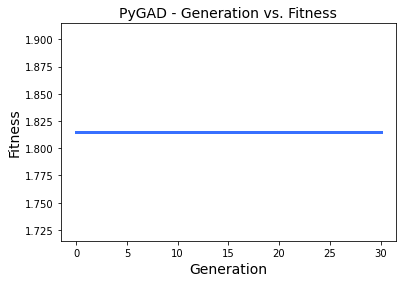

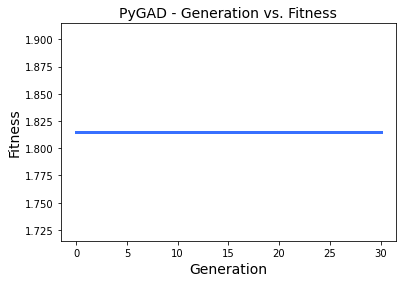

In [85]:
ga_instance.plot_fitness()

In [86]:
obtenerDatosCarga(solution,ofertaUtil)

,Clave,Nombre,Maestro,Lunes,Martes,Miercoles,Jueves,Viernes,Sabado
58,IL3422,Liderazgo y equipos de trabajo,García Rivera / Miriam Angelica,-,-,15:00-16:00,-,14:00-16:00,-
67,ID0307,Ingeniería de software,Morales Saavedra / Emmanuel,11:00-13:00,-,12:00-13:00,-,-,-
75,ID0310,Minería de datos,Gómez García / Hector Fernando,-,-,16:00-18:00,-,16:00-18:00,-
100,IT3472,Principios de automatización y robótica,Landaverde Lorenzo / Pablo Jacob,-,20:00-22:00,-,21:00-22:00,-,-
115,DP0499,Seminario de investigación,Reyes Miranda / José Felipe,14:00-16:00,-,14:00-15:00,-,-,-


In [87]:
desempeno = ga_instance.last_generation_fitness
desempeno.sort()
for a in desempeno:
    print(a)

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [88]:
claves = obtenerDatosCarga(solution,ofertaUtil)['Clave'].values
for clave in claves:
    print(plan_2016.query('clave == "' + clave + '"')['ciclos'].values)

[4]
[3]
[3]
[4]
[4]


## Prueba #3

keep_parents = False

In [89]:
kardex = obtenerKardex(190311499).query('periodo < 202201')
disponibilidad = disponibilidadArr[4] #Disponibilidad completa de horario
ofertaUtil = obtenerOfertaUtil(kardex,oferta)

In [90]:
obtenerCreditos(kardex)

240

In [91]:
obtenerMateriasReprobadas(kardex)

[]

In [92]:
fitness_function = obtenerDesempeno

num_generations = 30      #Número de generaciones
num_parents_mating = 2    #Número de padres por hijo

sol_per_pop = 500        #Tamaño de la poblacion
num_genes = 9             #Tamaño del cromosoma

gene_type = int           #Tipo de dato de los genes del cromosoma

parent_selection_type = "tournament"
keep_parents = 0          #Mantener a los padres vivos (La poblacion crece)

crossover_type = "two_points"

mutation_type = "random"
mutation_percent_genes = 15

gene_space = np.append(ofertaUtil.index.values,[-1])     #Valores que pueden tomar los genes

In [93]:
ga_instance = pg.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                       gene_type=gene_type,
                       gene_space=gene_space,
                       on_generation=on_generation)

In [94]:
start_time = time.time()
ga_instance.run()
print("--- Proceso terminado en: %s segundos---" % (time.time() - start_time))

Generación: 1
Generación: 2
Generación: 3
Generación: 4
Generación: 5
Generación: 6
Generación: 7
Generación: 8
Generación: 9
Generación: 10
Generación: 11
Generación: 12
Generación: 13
Generación: 14
Generación: 15
Generación: 16
Generación: 17
Generación: 18
Generación: 19
Generación: 20
Generación: 21
Generación: 22
Generación: 23
Generación: 24
Generación: 25
Generación: 26
Generación: 27
Generación: 28
Generación: 29
Generación: 30
--- Proceso terminado en: 21.904333353042603 segundos---


In [95]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print(solution_fitness)

1.575237072821614


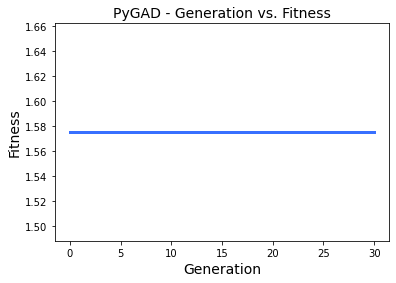

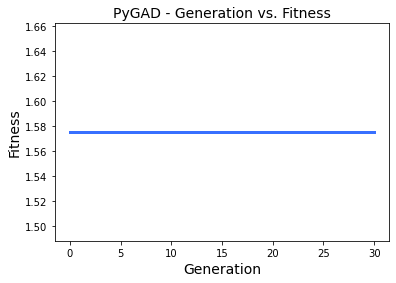

In [96]:
ga_instance.plot_fitness()

In [97]:
obtenerDatosCarga(solution,ofertaUtil)

,Clave,Nombre,Maestro,Lunes,Martes,Miercoles,Jueves,Viernes,Sabado
65,II0422,Taller de emprendedores,Arreola Mejía / Sonia Amalia,-,13:00-15:00,-,13:00-14:00,-,-
69,ID3416,Diseño multimedia,Landeros Alvarado / Aurea,-,08:00-09:00,-,09:00-11:00,-,-
76,ID3422,Negocios digitales,Rodríguez Santiago / Juan Manuel,-,18:00-20:00,-,18:00-19:00,-,-
97,ID3423,Sistemas de apoyo para la toma de decisiones,Mendiola Fuentes / Jessica Carmin,-,16:00-18:00,-,17:00-18:00,-,-
98,IT0423,Administración de proyectos de desarrollo de s...,Galvan Herrera / Maria Fernanda,19:00-21:00,-,-,20:00-21:00,-,-
100,IT3472,Principios de automatización y robótica,Landaverde Lorenzo / Pablo Jacob,-,20:00-22:00,-,21:00-22:00,-,-
110,DP0498,Problemas de México,Barragan Garcia / Marco Antonio,-,-,16:00-18:00,-,16:00-17:00,-


In [98]:
desempeno = ga_instance.last_generation_fitness
desempeno.sort()
for a in desempeno:
    print(a)

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [99]:
claves = obtenerDatosCarga(solution,ofertaUtil)['Clave'].values
for clave in claves:
    print(plan_2016.query('clave == "' + clave + '"')['ciclos'].values)

[4]
[3]
[3]
[4]
[4]
[4]
[3]


In [100]:
evaluarSolucion(ga_instance.population[45])

La carga evaluada tiene:
	4.12% de utilidad por las materias de primeros ciclos llevadas.
	0% del total de las materias reprobadas del estudiante.
	0% de costo por sobreposición con las horas donde el estudiante no está disponible.
	63.16% de costo por el total de horas libres por día.


In [101]:
obtenerDesempeno(ga_instance.population[45],0)

0

In [102]:
obtenerDatosCarga(ga_instance.population[25],ofertaUtil)

,Clave,Nombre,Maestro,Lunes,Martes,Miercoles,Jueves,Viernes,Sabado
67,ID0307,Ingeniería de software,Morales Saavedra / Emmanuel,11:00-13:00,-,12:00-13:00,-,-,-
71,II0422,Taller de emprendedores,Treviño Arzápalo / Ángel Alejandro,07:00-09:00,-,07:00-08:00,-,-,-
95,ID3415,Cómputo ubicuo,Sansores Pérez / Candelaria Elizabeth,-,-,18:00-20:00,-,18:00-19:00,-
97,ID3423,Sistemas de apoyo para la toma de decisiones,Mendiola Fuentes / Jessica Carmin,-,16:00-18:00,-,17:00-18:00,-,-
101,NI3431,Marketing en los negocios electrónicos,Canche Dzul / Arely Del Socorro,21:00-22:00,-,-,-,19:00-21:00,-
108,IT0317,Diseño de interfaces humano-máquina,Morales Saavedra / Emmanuel,-,-,15:00-16:00,-,14:00-16:00,-
111,DP0499,Seminario de investigación,Reyes Miranda / José Felipe,16:00-18:00,-,18:00-19:00,-,-,-
113,ID3424,Visualización de datos,Mendiola Fuentes / Jessica Carmin,07:00-08:00,-,-,-,07:00-09:00,-


## Prueba #4

steady-state selection

In [103]:
kardex = obtenerKardex(190311499).query('periodo < 202201')
disponibilidad = disponibilidadArr[4] #Disponibilidad completa de horario
ofertaUtil = obtenerOfertaUtil(kardex,oferta)

In [104]:
obtenerCreditos(kardex)

240

In [105]:
obtenerMateriasReprobadas(kardex)

[]

In [106]:
fitness_function = obtenerDesempeno

num_generations = 30      #Número de generaciones
num_parents_mating = 2    #Número de padres por hijo

sol_per_pop = 500        #Tamaño de la poblacion
num_genes = 9             #Tamaño del cromosoma

gene_type = int           #Tipo de dato de los genes del cromosoma

parent_selection_type = "sss"
keep_parents = 1          #Mantener a los padres vivos (La poblacion crece)

crossover_type = "two_points"

mutation_type = "random"
mutation_percent_genes = 15

gene_space = np.append(ofertaUtil.index.values,[-1])     #Valores que pueden tomar los genes

In [107]:
ga_instance = pg.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                       gene_type=gene_type,
                       gene_space=gene_space,
                       on_generation=on_generation)

In [108]:
start_time = time.time()
ga_instance.run()
print("--- Proceso terminado en: %s segundos---" % (time.time() - start_time))

Generación: 1
Generación: 2
Generación: 3
Generación: 4
Generación: 5
Generación: 6
Generación: 7
Generación: 8
Generación: 9
Generación: 10
Generación: 11
Generación: 12
Generación: 13
Generación: 14
Generación: 15
Generación: 16
Generación: 17
Generación: 18
Generación: 19
Generación: 20
Generación: 21
Generación: 22
Generación: 23
Generación: 24
Generación: 25
Generación: 26
Generación: 27
Generación: 28
Generación: 29
Generación: 30
--- Proceso terminado en: 182.50124526023865 segundos---


In [109]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print(solution_fitness)

2.0781893004115224


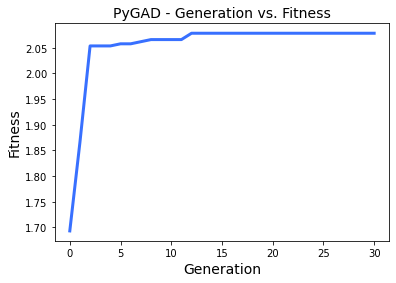

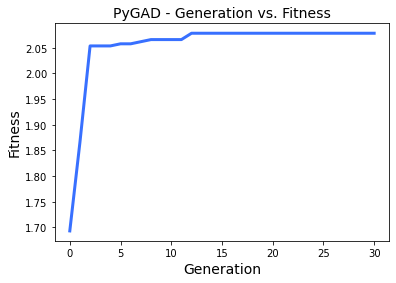

In [110]:
ga_instance.plot_fitness()

In [111]:
obtenerDatosCarga(solution,ofertaUtil)

,Clave,Nombre,Maestro,Lunes,Martes,Miercoles,Jueves,Viernes,Sabado
58,IL3422,Liderazgo y equipos de trabajo,García Rivera / Miriam Angelica,-,-,15:00-16:00,-,14:00-16:00,-
74,ID0307,Ingeniería de software,Aguas García / Nancy,-,16:00-18:00,-,16:00-17:00,-,-
75,ID0310,Minería de datos,Gómez García / Hector Fernando,-,-,16:00-18:00,-,16:00-18:00,-
76,ID3422,Negocios digitales,Rodríguez Santiago / Juan Manuel,-,18:00-20:00,-,18:00-19:00,-,-
77,ID3468,Herramientas para la gestión de grandes volúme...,Mendiola Fuentes / Jessica Carmin,18:00-20:00,-,-,19:00-20:00,-,-
78,II0422,Taller de emprendedores,García Rivera / Miriam Angelica,16:00-18:00,-,-,17:00-18:00,-,-
79,IT0263,Electrónica analógica,Márquez Chacón / Wilberth,-,-,18:00-20:00,-,18:00-19:00,-
102,DP0498,Problemas de México,Díaz Molina / Libertad Fidelina,-,14:00-16:00,-,15:00-16:00,-,-
105,DP0499,Seminario de investigación,Barragan Garcia / Marco Antonio,-,20:00-22:00,-,20:00-21:00,-,-


In [112]:
desempeno = ga_instance.last_generation_fitness
desempeno.sort()
for a in desempeno:
    print(a)

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [113]:
claves = obtenerDatosCarga(solution,ofertaUtil)['Clave'].values
for clave in claves:
    print(plan_2016.query('clave == "' + clave + '"')['ciclos'].values)

[4]
[3]
[3]
[3]
[4]
[4]
[3]
[3]
[4]


In [114]:
evaluarSolucion(solution)

La carga evaluada tiene:
	7.82% de utilidad por las materias de primeros ciclos llevadas.
	0% del total de las materias reprobadas del estudiante.
	0% de costo por sobreposición con las horas donde el estudiante no está disponible.
	0.0% de costo por el total de horas libres por día.


## Prueba #5

steady-state selection, uniform crossover

In [115]:
kardex = obtenerKardex(190311499).query('periodo < 202201')
disponibilidad = disponibilidadArr[4] #Disponibilidad completa de horario
ofertaUtil = obtenerOfertaUtil(kardex,oferta)

In [116]:
obtenerCreditos(kardex)

240

In [117]:
obtenerMateriasReprobadas(kardex)

[]

In [118]:
fitness_function = obtenerDesempeno

num_generations = 30      #Número de generaciones
num_parents_mating = 2    #Número de padres por hijo

sol_per_pop = 500        #Tamaño de la poblacion
num_genes = 9             #Tamaño del cromosoma

gene_type = int           #Tipo de dato de los genes del cromosoma

parent_selection_type = "sss"
keep_parents = 1          #Mantener a los padres vivos (La poblacion crece)

crossover_type = "uniform"

mutation_type = "random"
mutation_percent_genes = 15

gene_space = np.append(ofertaUtil.index.values,[-1])     #Valores que pueden tomar los genes

In [119]:
ga_instance = pg.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                       gene_type=gene_type,
                       gene_space=gene_space,
                       on_generation=on_generation)

In [120]:
start_time = time.time()
ga_instance.run()
print("--- Proceso terminado en: %s segundos---" % (time.time() - start_time))

Generación: 1
Generación: 2
Generación: 3
Generación: 4
Generación: 5
Generación: 6
Generación: 7
Generación: 8
Generación: 9
Generación: 10
Generación: 11
Generación: 12
Generación: 13
Generación: 14
Generación: 15
Generación: 16
Generación: 17
Generación: 18
Generación: 19
Generación: 20
Generación: 21
Generación: 22
Generación: 23
Generación: 24
Generación: 25
Generación: 26
Generación: 27
Generación: 28
Generación: 29
Generación: 30
--- Proceso terminado en: 175.89098596572876 segundos---


In [121]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print(solution_fitness)

2.0781893004115224


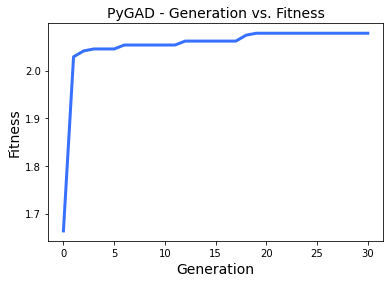

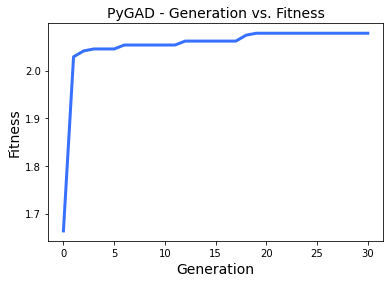

In [122]:
ga_instance.plot_fitness()

In [123]:
obtenerDatosCarga(solution,ofertaUtil)

,Clave,Nombre,Maestro,Lunes,Martes,Miercoles,Jueves,Viernes,Sabado
74,ID0307,Ingeniería de software,Aguas García / Nancy,-,16:00-18:00,-,16:00-17:00,-,-
75,ID0310,Minería de datos,Gómez García / Hector Fernando,-,-,16:00-18:00,-,16:00-18:00,-
76,ID3422,Negocios digitales,Rodríguez Santiago / Juan Manuel,-,18:00-20:00,-,18:00-19:00,-,-
77,ID3468,Herramientas para la gestión de grandes volúme...,Mendiola Fuentes / Jessica Carmin,18:00-20:00,-,-,19:00-20:00,-,-
78,II0422,Taller de emprendedores,García Rivera / Miriam Angelica,16:00-18:00,-,-,17:00-18:00,-,-
79,IT0263,Electrónica analógica,Márquez Chacón / Wilberth,-,-,18:00-20:00,-,18:00-19:00,-
102,DP0498,Problemas de México,Díaz Molina / Libertad Fidelina,-,14:00-16:00,-,15:00-16:00,-,-
108,IT0317,Diseño de interfaces humano-máquina,Morales Saavedra / Emmanuel,-,-,15:00-16:00,-,14:00-16:00,-
115,DP0499,Seminario de investigación,Reyes Miranda / José Felipe,14:00-16:00,-,14:00-15:00,-,-,-


In [124]:
desempeno = ga_instance.last_generation_fitness
desempeno.sort()
for a in desempeno:
    print(a)

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [125]:
claves = obtenerDatosCarga(solution,ofertaUtil)['Clave'].values
for clave in claves:
    print(plan_2016.query('clave == "' + clave + '"')['ciclos'].values)

[3]
[3]
[3]
[4]
[4]
[3]
[3]
[4]
[4]


In [126]:
evaluarSolucion(solution)

La carga evaluada tiene:
	7.82% de utilidad por las materias de primeros ciclos llevadas.
	0% del total de las materias reprobadas del estudiante.
	0% de costo por sobreposición con las horas donde el estudiante no está disponible.
	0.0% de costo por el total de horas libres por día.


## Prueba #6

steady-state selection, uniform crossover, adaptive mutation

In [127]:
kardex = obtenerKardex(190311499).query('periodo < 202201')
disponibilidad = disponibilidadArr[4] #Disponibilidad completa de horario
ofertaUtil = obtenerOfertaUtil(kardex,oferta)

In [128]:
obtenerCreditos(kardex)

240

In [129]:
obtenerMateriasReprobadas(kardex)

[]

In [130]:
fitness_function = obtenerDesempeno

num_generations = 30      #Número de generaciones
num_parents_mating = 2    #Número de padres por hijo

sol_per_pop = 500        #Tamaño de la poblacion
num_genes = 9             #Tamaño del cromosoma

gene_type = int           #Tipo de dato de los genes del cromosoma

parent_selection_type = "sss"
keep_parents = 1          #Mantener a los padres vivos (La poblacion crece)

crossover_type = "uniform"

mutation_type = "adaptive"
mutation_probability = [0.35,0.1]

gene_space = np.append(ofertaUtil.index.values,[-1])     #Valores que pueden tomar los genes

In [131]:
ga_instance = pg.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_probability=mutation_probability,
                       gene_type=gene_type,
                       gene_space=gene_space,
                       on_generation=on_generation)

In [132]:
start_time = time.time()
ga_instance.run()
print("--- Proceso terminado en: %s segundos---" % (time.time() - start_time))

Generación: 1
Generación: 2
Generación: 3
Generación: 4
Generación: 5
Generación: 6
Generación: 7
Generación: 8
Generación: 9
Generación: 10
Generación: 11
Generación: 12
Generación: 13
Generación: 14
Generación: 15
Generación: 16
Generación: 17
Generación: 18
Generación: 19
Generación: 20
Generación: 21
Generación: 22
Generación: 23
Generación: 24
Generación: 25
Generación: 26
Generación: 27
Generación: 28
Generación: 29
Generación: 30
--- Proceso terminado en: 560.1261646747589 segundos---


In [133]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print(solution_fitness)

2.0658436213991767


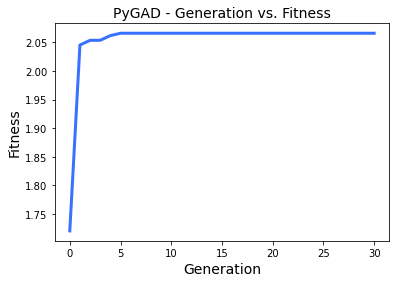

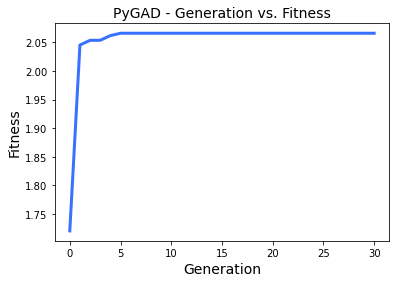

In [134]:
ga_instance.plot_fitness()

In [135]:
obtenerDatosCarga(solution,ofertaUtil)

,Clave,Nombre,Maestro,Lunes,Martes,Miercoles,Jueves,Viernes,Sabado
58,IL3422,Liderazgo y equipos de trabajo,García Rivera / Miriam Angelica,-,-,15:00-16:00,-,14:00-16:00,-
73,DP0498,Problemas de México,Manzo de León / Leonela Paola,20:00-22:00,-,20:00-21:00,-,-,-
75,ID0310,Minería de datos,Gómez García / Hector Fernando,-,-,16:00-18:00,-,16:00-18:00,-
76,ID3422,Negocios digitales,Rodríguez Santiago / Juan Manuel,-,18:00-20:00,-,18:00-19:00,-,-
77,ID3468,Herramientas para la gestión de grandes volúme...,Mendiola Fuentes / Jessica Carmin,18:00-20:00,-,-,19:00-20:00,-,-
79,IT0263,Electrónica analógica,Márquez Chacón / Wilberth,-,-,18:00-20:00,-,18:00-19:00,-
97,ID3423,Sistemas de apoyo para la toma de decisiones,Mendiola Fuentes / Jessica Carmin,-,16:00-18:00,-,17:00-18:00,-,-
105,DP0499,Seminario de investigación,Barragan Garcia / Marco Antonio,-,20:00-22:00,-,20:00-21:00,-,-


In [136]:
desempeno = ga_instance.last_generation_fitness
desempeno.sort()
for a in desempeno:
    print(a)

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.4825102880658436
1.498789639312515
1.5070200919874122
1.5121586232697344
1.5121586232697344
1.5121586232697344
1.5199588477366255
1.5263631687242798
1.5263631687242798
1.5334979423868313
1.534593621

In [137]:
claves = obtenerDatosCarga(solution,ofertaUtil)['Clave'].values
for clave in claves:
    print(plan_2016.query('clave == "' + clave + '"')['ciclos'].values)

[4]
[3]
[3]
[3]
[4]
[3]
[4]
[4]


In [138]:
evaluarSolucion(solution)

La carga evaluada tiene:
	6.58% de utilidad por las materias de primeros ciclos llevadas.
	0% del total de las materias reprobadas del estudiante.
	0% de costo por sobreposición con las horas donde el estudiante no está disponible.
	0.0% de costo por el total de horas libres por día.


**Resultados:** El algoritmo evolutivo parece encontrar sino un óptimo global, al menos un desempeño bastante bueno para la población en general en pocas generaciones. Solamente falta comprobar si la función de desempeño es adecuada, para hay que evaluar los "mejores resultados".

## Prueba 7

In [ ]:
kardex = obtenerKardex(190311499).query('periodo < 202201')
disponibilidad = disponibilidadArr[4] #Disponibilidad completa de horario
ofertaUtil = obtenerOfertaUtil(kardex,oferta)

In [ ]:
obtenerCreditos(kardex)

In [ ]:
obtenerMateriasReprobadas(kardex)

In [ ]:
fitness_function = obtenerDesempeno

num_generations = 30      #Número de generaciones
num_parents_mating = 2    #Número de padres por hijo

sol_per_pop = 500        #Tamaño de la poblacion
num_genes = 9             #Tamaño del cromosoma

gene_type = int           #Tipo de dato de los genes del cromosoma

parent_selection_type = "sss"
keep_parents = 1          #Mantener a los padres vivos (La poblacion crece)

crossover_type = "single_point"

mutation_type = "adaptive"
mutation_probability = [0.35,0.1]

gene_space = np.append(ofertaUtil.index.values,[-1])     #Valores que pueden tomar los genes

In [ ]:
ga_instance = pg.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_probability=mutation_probability,
                       gene_type=gene_type,
                       gene_space=gene_space,
                       on_generation=on_generation)

In [ ]:
start_time = time.time()
ga_instance.run()
print("--- Proceso terminado en: %s segundos---" % (time.time() - start_time))

In [ ]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print(solution_fitness)

In [ ]:
ga_instance.plot_fitness()

In [ ]:
obtenerDatosCarga(solution,ofertaUtil)

In [ ]:
desempeno = ga_instance.last_generation_fitness
desempeno.sort()
for a in desempeno:
    print(a)

In [ ]:
claves = obtenerDatosCarga(solution,ofertaUtil)['Clave'].values
for clave in claves:
    print(plan_2016.query('clave == "' + clave + '"')['ciclos'].values)

In [ ]:
evaluarSolucion(solution)

# Evaluacion

Para encontrar el mejor algoritmo vamos a probar 100 kardex diferentes y aplicar cada algoritmo con un total de 20 generaciones. Posteriormente evaluaremos los mejores desempeños de cada algoritmo aplicado a cada kardex para identificar el que obtuvo mejores resultados en promedio.

In [224]:
matriculas_set = set()
while len(matriculas_set) < 100:
    matriculas_set.add(np.random.choice(matriculas))

In [225]:
kardexArr = []
for matricula in matriculas_set:
    kardexArr.append(obtenerKardex(matricula))

In [209]:
num_generations = 20

for kardex in kardexArr:
    print('Iniciando proceso de matricula: ' + str(kardex.iloc[0]["n_matricula"]))
    disponibilidad = disponibilidadArr[4] #Disponibilidad completa de horario
    ofertaUtil = obtenerOfertaUtil(kardex,oferta)

    #Cruce: Uniforme
    #Mutacion: Aleatoria
    instancia1 = pg.GA(num_generations=num_generations,
                       num_parents_mating=2,
                       fitness_func=obtenerDesempeno,
                       sol_per_pop=500,
                       num_genes=9,
                       parent_selection_type="sss",
                       keep_parents=1,
                       crossover_type='uniform',
                       mutation_type='random',
                       mutation_percent_genes=15,
                       gene_type=int,
                       gene_space=np.append(ofertaUtil.index.values,[-1]))

    start_time = time.time()
    instancia1.run()
    tiempoejecucion1 = time.time() - start_time
    generacionDeMejorSolucion1 = instancia1.best_solution_generation
    solution1, solution_fitness1, solution_idx = instancia1.best_solution()
    
    desempenos = instancia1.last_generation_fitness.copy()
    desempenos = desempenos[desempenos != 0]
    if len(desempenos) > 0:
        desempenoPoblacionNoCero1 = sum(desempenos) / (len(desempenos))
    minimo1 = min(desempenos)
    
    print("--- Instancia 1 terminada en: %s segundos---" % (tiempoejecucion1))
    print("Desempeño: " + str(solution_fitness1))
    print("Solucion: " + str(solution1))
    print("Mejor generacion: "+ str(generacionDeMejorSolucion1))
    print('Peor solucion: ' + str(minimo1))
    print('Promedio desempeño: ' + str(desempenoPoblacionNoCero1))

    #Cruce: Un punto
    #Mutacion: Aleatoria
    instancia2 = pg.GA(num_generations=num_generations,
                       num_parents_mating=2,
                       fitness_func=obtenerDesempeno,
                       sol_per_pop=500,
                       num_genes=9,
                       parent_selection_type="sss",
                       keep_parents=1,
                       crossover_type='single_point',
                       mutation_type='random',
                       mutation_percent_genes=15,
                       gene_type=int,
                       gene_space=np.append(ofertaUtil.index.values,[-1]))


    start_time = time.time()
    instancia2.run()
    tiempoejecucion2 = time.time() - start_time
    generacionDeMejorSolucion2 = instancia2.best_solution_generation
    solution2, solution_fitness2, solution_idx = instancia2.best_solution()
    
    desempenos = instancia2.last_generation_fitness.copy()
    desempenos = desempenos[desempenos != 0]
    if len(desempenos) > 0:
        desempenoPoblacionNoCero2 = sum(desempenos) / (len(desempenos))
    minimo2 = min(desempenos)
    
    print("--- Instancia 2 terminada en: %s segundos---" % (tiempoejecucion2))
    print("Desempeño: " + str(solution_fitness2))
    print("Solucion: " + str(solution2))
    print("Mejor generacion: "+ str(generacionDeMejorSolucion2))
    print('Peor solucion: ' + str(minimo2))
    print('Promedio desempeño: ' + str(desempenoPoblacionNoCero2))
    
    #Cruce: Dos puntos
    #Mutacion: Aleatoria
    instancia3 = pg.GA(num_generations=num_generations,
                       num_parents_mating=2,
                       fitness_func=obtenerDesempeno,
                       sol_per_pop=500,
                       num_genes=9,
                       parent_selection_type="sss",
                       keep_parents=1,
                       crossover_type='two_points',
                       mutation_type='random',
                       mutation_percent_genes=15,
                       gene_type=int,
                       gene_space=np.append(ofertaUtil.index.values,[-1]))

    start_time = time.time()
    instancia3.run()
    tiempoejecucion3 = time.time() - start_time
    generacionDeMejorSolucion3 = instancia3.best_solution_generation
    solution3, solution_fitness3, solution_idx = instancia3.best_solution()
    
    desempenos = instancia3.last_generation_fitness.copy()
    desempenos = desempenos[desempenos != 0]
    if len(desempenos) > 0:
        desempenoPoblacionNoCero3 = sum(desempenos) / (len(desempenos))
    minimo3 = min(desempenos)
    
    print("--- Instancia 3 terminada en: %s segundos---" % (tiempoejecucion3))
    print("Desempeño: " + str(solution_fitness3))
    print("Solucion: " + str(solution3))
    print("Mejor generacion: "+ str(generacionDeMejorSolucion3))
    print('Peor solucion: ' + str(minimo3))
    print('Promedio desempeño: ' + str(desempenoPoblacionNoCero3))

    #Cruce: Uniforme
    #Mutacion: Adaptativa
    instancia4 = pg.GA(num_generations=num_generations,
                       num_parents_mating=2,
                       fitness_func=obtenerDesempeno,
                       sol_per_pop=500,
                       num_genes=9,
                       parent_selection_type="sss",
                       keep_parents=1,
                       crossover_type='uniform',
                       mutation_type = "adaptive",
                       mutation_probability = [0.35,0.1],
                       gene_type=int,
                       gene_space=np.append(ofertaUtil.index.values,[-1]))

    start_time = time.time()
    instancia4.run()
    tiempoejecucion4 = time.time() - start_time
    generacionDeMejorSolucion4 = instancia4.best_solution_generation
    solution4, solution_fitness4, solution_idx = instancia4.best_solution()
    
    desempenos = instancia4.last_generation_fitness.copy()
    desempenos = desempenos[desempenos != 0]
    if len(desempenos) > 0:
        desempenoPoblacionNoCero4 = sum(desempenos) / (len(desempenos))
    minimo4 = min(desempenos)
    
    print("--- Instancia 4 terminada en: %s segundos---" % (tiempoejecucion4))
    print("Desempeño: " + str(solution_fitness4))
    print("Solucion: " + str(solution4))
    print("Mejor generacion: "+ str(generacionDeMejorSolucion4))
    print('Peor solucion: ' + str(minimo4))
    print('Promedio desempeño: ' + str(desempenoPoblacionNoCero4))

    #Cruce: Un punto
    #Mutacion: Adaptativa
    instancia5 = pg.GA(num_generations=num_generations,
                       num_parents_mating=2,
                       fitness_func=obtenerDesempeno,
                       sol_per_pop=500,
                       num_genes=9,
                       parent_selection_type="sss",
                       keep_parents=1,
                       crossover_type='single_point',
                       mutation_type = "adaptive",
                       mutation_probability = [0.35,0.1],
                       gene_type=int,
                       gene_space=np.append(ofertaUtil.index.values,[-1]))

    start_time = time.time()
    instancia5.run()
    tiempoejecucion5 = time.time() - start_time
    generacionDeMejorSolucion5 = instancia5.best_solution_generation
    solution5, solution_fitness5, solution_idx = instancia5.best_solution()
    
    desempenos = instancia5.last_generation_fitness.copy()
    desempenos = desempenos[desempenos != 0]
    if len(desempenos) > 0:
        desempenoPoblacionNoCero5 = sum(desempenos) / (len(desempenos))
    minimo5 = min(desempenos)
    
    print("--- Instancia 5 terminada en: %s segundos---" % (tiempoejecucion5))
    print("Desempeño: " + str(solution_fitness5))
    print("Solucion: " + str(solution5))
    print("Mejor generacion: "+ str(generacionDeMejorSolucion5))
    print('Peor solucion: ' + str(minimo5))
    print('Promedio desempeño: ' + str(desempenoPoblacionNoCero5))

    #Cruce: Dos puntos
    #Mutacion: Adaptativa
    instancia6 = pg.GA(num_generations=num_generations,
                       num_parents_mating=2,
                       fitness_func=obtenerDesempeno,
                       sol_per_pop=500,
                       num_genes=9,
                       parent_selection_type="sss",
                       keep_parents=1,
                       crossover_type='two_points',
                       mutation_type = "adaptive",
                       mutation_probability = [0.35,0.1],
                       gene_type=int,
                       gene_space=np.append(ofertaUtil.index.values,[-1]))

    start_time = time.time()
    instancia6.run()
    tiempoejecucion6 = time.time() - start_time
    generacionDeMejorSolucion6 = instancia6.best_solution_generation
    solution6, solution_fitness6, solution_idx = instancia6.best_solution()
    
    desempenos = instancia6.last_generation_fitness.copy()
    desempenos = desempenos[desempenos != 0]
    if len(desempenos) > 0:
        desempenoPoblacionNoCero6 = sum(desempenos) / (len(desempenos))
    minimo6 = min(desempenos)
    
    print("--- Instancia 6 terminada en: %s segundos---" % (tiempoejecucion6))
    print("Desempeño: " + str(solution_fitness6))
    print("Solucion: " + str(solution6))
    print("Mejor generacion: "+ str(generacionDeMejorSolucion6))
    print('Peor solucion: ' + str(minimo6))
    print('Promedio desempeño: ' + str(desempenoPoblacionNoCero6))
    
    requests.post('https://resultados-api.azurewebsites.net/registrar', json = {
            'n_matricula': str(kardex.iloc[0]["n_matricula"]),
            'tiempoEjecucion1': str(tiempoejecucion1),'mejorGeneracion1': str(generacionDeMejorSolucion1),'solucion1': str(solution1),'desempeno1': str(solution_fitness1),'desempenoPoblacionNoCero1': str(desempenoPoblacionNoCero1),'desempenoMinimo1': str(minimo1),
            'tiempoEjecucion2': str(tiempoejecucion2),'mejorGeneracion2': str(generacionDeMejorSolucion2),'solucion2': str(solution2),'desempeno2': str(solution_fitness2),'desempenoPoblacionNoCero2': str(desempenoPoblacionNoCero2),'desempenoMinimo2': str(minimo2),
            'tiempoEjecucion3': str(tiempoejecucion3),'mejorGeneracion3': str(generacionDeMejorSolucion3),'solucion3': str(solution3),'desempeno3': str(solution_fitness3),'desempenoPoblacionNoCero3': str(desempenoPoblacionNoCero3),'desempenoMinimo3': str(minimo3),
            'tiempoEjecucion4': str(tiempoejecucion4),'mejorGeneracion4': str(generacionDeMejorSolucion4),'solucion4': str(solution4),'desempeno4': str(solution_fitness4),'desempenoPoblacionNoCero4': str(desempenoPoblacionNoCero4),'desempenoMinimo4': str(minimo4),
            'tiempoEjecucion5': str(tiempoejecucion5),'mejorGeneracion5': str(generacionDeMejorSolucion5),'solucion5': str(solution5),'desempeno5': str(solution_fitness5),'desempenoPoblacionNoCero5': str(desempenoPoblacionNoCero5),'desempenoMinimo5': str(minimo5),
            'tiempoEjecucion6': str(tiempoejecucion6),'mejorGeneracion6': str(generacionDeMejorSolucion6),'solucion6': str(solution6),'desempeno6': str(solution_fitness6),'desempenoPoblacionNoCero6': str(desempenoPoblacionNoCero6),'desempenoMinimo6': str(minimo6),
    })

    print("\n\nPROCESO TERMINADO EN " + str(tiempoejecucion6 + tiempoejecucion1 + tiempoejecucion2 + tiempoejecucion3 + tiempoejecucion4 + tiempoejecucion5))
    print('--------------------------------------------------------------------')

Iniciando proceso de matricula: 180311438
--- Instancia 1 terminada en: 171.25942492485046 segundos---
Desempeño: 2.0246913580246915
Solucion: [101 100  98  95  97  94 100  95 101]
Mejor generacion: 1
Peor solucion: 1.2746913580246915
Promedio desempeño: 1.7769716496320962
--- Instancia 2 terminada en: 185.53379273414612 segundos---
Desempeño: 2.0246913580246915
Solucion: [ 97 101  95  98 101  98  94 101 100]
Mejor generacion: 1
Peor solucion: 1.2746913580246915
Promedio desempeño: 1.7369178348186305
--- Instancia 3 terminada en: 227.2365481853485 segundos---
Desempeño: 2.0246913580246915
Solucion: [101 100  -1  94  95  97  98  95 100]
Mejor generacion: 3
Peor solucion: 1.1768261316872428
Promedio desempeño: 1.698356560087847
--- Instancia 4 terminada en: 395.54182267189026 segundos---
Desempeño: 2.0246913580246915
Solucion: [ 98  97  95 101 100  97  94  94  98]
Mejor generacion: 0
Peor solucion: 1.192989924790691
Promedio desempeño: 1.8620858997347678
--- Instancia 5 terminada en: 309

In [ ]:
solution, solution_fitness, solution_idx = instancia1.best_solution()

In [ ]:
solution

In [ ]:
solution_fitness

In [ ]:
instancia1.plot_fitness()

In [ ]:
instancia2.plot_fitness()

In [ ]:
instancia3.plot_fitness()

In [ ]:
instancia4.plot_fitness()

In [ ]:
instancia5.plot_fitness()

In [ ]:
instancia6.plot_fitness()

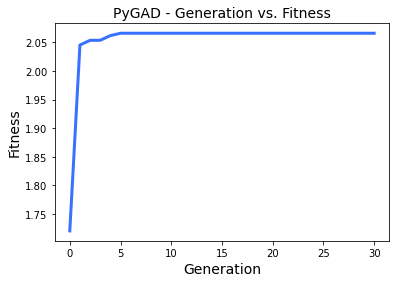

In [193]:
plot = ga_instance.plot_fitness()

In [216]:
resultados = requests.get('https://resultados-api.azurewebsites.net/').json()
pd.DataFrame(resultados)

,id,hora,tiempodeejecucion,mejorgeneracion,numeroinstancia,solucion,desempeno,matricula,desempenopoblacionnocero,desempenominimo
0,29,2023-03-16T07:44:08.539Z,185.533793,1,2,[ 97 101 95 98 101 98 94 101 100],2.024691,180311438,1.736918,1.274691
1,30,2023-03-16T07:44:08.539Z,227.236548,3,3,[101 100 -1 94 95 97 98 95 100],2.024691,180311438,1.698357,1.176826
2,31,2023-03-16T07:44:08.539Z,395.541823,0,4,[ 98 97 95 101 100 97 94 94 98],2.024691,180311438,1.862086,1.192990
3,32,2023-03-16T07:44:08.539Z,309.702503,2,5,[ 97 95 101 100 98 -1 94 101 97],2.024691,180311438,1.863529,1.272331
4,33,2023-03-16T07:44:08.539Z,319.624894,1,6,[ 95 100 101 -1 94 -1 -1 97 98],2.024691,180311438,1.799272,1.176826


In [223]:
requests.post('https://resultados-api.azurewebsites.net/registrar', json = {
    'n_matricula': str(kardex.iloc[0]["n_matricula"]),
        'tiempoEjecucion1': str(tiempoejecucion1),'mejorGeneracion1': str(generacionDeMejorSolucion1),'solucion1': str(solution1),'desempeno1': str(solution_fitness1),'desempenoPoblacionNoCero1': str(desempenoPoblacionNoCero1),'desempenoMinimo1': str(minimo1),
        'tiempoEjecucion2': str(tiempoejecucion2),'mejorGeneracion2': str(generacionDeMejorSolucion2),'solucion2': str(solution2),'desempeno2': str(solution_fitness2),'desempenoPoblacionNoCero2': str(desempenoPoblacionNoCero2),'desempenoMinimo2': str(minimo2),
        'tiempoEjecucion3': str(tiempoejecucion3),'mejorGeneracion3': str(generacionDeMejorSolucion3),'solucion3': str(solution3),'desempeno3': str(solution_fitness3),'desempenoPoblacionNoCero3': str(desempenoPoblacionNoCero3),'desempenoMinimo3': str(minimo3),
        'tiempoEjecucion4': str(tiempoejecucion4),'mejorGeneracion4': str(generacionDeMejorSolucion4),'solucion4': str(solution4),'desempeno4': str(solution_fitness4),'desempenoPoblacionNoCero4': str(desempenoPoblacionNoCero4),'desempenoMinimo4': str(minimo4),
        'tiempoEjecucion5': str(tiempoejecucion5),'mejorGeneracion5': str(generacionDeMejorSolucion5),'solucion5': str(solution5),'desempeno5': str(solution_fitness5),'desempenoPoblacionNoCero5': str(desempenoPoblacionNoCero5),'desempenoMinimo5': str(minimo5),
        'tiempoEjecucion6': str(tiempoejecucion6),'mejorGeneracion6': str(generacionDeMejorSolucion6),'solucion6': str(solution6),'desempeno6': str(solution_fitness6),'desempenoPoblacionNoCero6': str(desempenoPoblacionNoCero6),'desempenoMinimo6': str(minimo6),
})

<Response [200]>

In [231]:
import random

In [233]:
mlist = list(matriculas_set)
random.shuffle(mlist)

In [236]:
mlist[0:10]

[200311084,
 160311986,
 200311082,
 170311921,
 160311248,
 160311215,
 210311744,
 170311288,
 170311156,
 200311026]